<a href="https://colab.research.google.com/github/DinethRubeh/Cotton-Disease-Prediction/blob/master/Model_Training_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cotton Disease Prediction - Model Training using Transfer Learning
**Resnet50** is used in this notebook.

In [ ]:
# !pip install tensorflow-gpu

In [ ]:
# !nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [ ]:
# Resize images
img_height = 224
img_width = 224
image_size = [img_height, img_width, 3] # height, width, depth

# Output classes
predict_class_size = 4

# Train/validation image path
train_dir = '/content/drive/My Drive/google colab/cotton_data/train'
test_dir = '/content/drive/My Drive/google colab/cotton_data/val'

# Train/validation image dataset count (inside sub-directories)
train_data_count = sum([len(files) for _, _, files in os.walk("/content/drive/My Drive/google colab/cotton_data/train")])
test_data_count = sum([len(files) for _, _, files in os.walk("/content/drive/My Drive/google colab/cotton_data/val")])

In [ ]:
print(train_data_count, test_data_count)

1951 324


In [ ]:
# Intialize Resnet50 with imagenet weights
resnet = ResNet50(input_shape=image_size, weights='imagenet', include_top=False)

# Freeze model weights (don't train)
for layer in resnet.layers:
    layer.trainable = False
    
# layers
x = Flatten()(resnet.output)

# output layer
pred_layer = Dense(predict_class_size, activation='softmax')(x)

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
# create model object
model = Model(inputs=resnet.input, outputs=pred_layer)

# Model structure
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# Set cost and optimization functions for model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
# Image Data Augmentation using keras ImageDataGenerator

train_aug = ImageDataGenerator(rescale=1./255, 
                               rotation_range=30, 
                              #  width_shift_range=0.2, # horizontal shift
                              #  height_shift_range=0.2, # vertical shift
                               horizontal_flip=True, 
                              #  vertical_flip=True, 
                               zoom_range=0.2, # ~ [1-0.2, 1+0.2]
                               brightness_range=[0.5,1.5]) # <1 darkens img, >1 brightens img
# only scale the test images
test_aug = ImageDataGenerator(rescale=1./255)

### Create Training and testing datasets with generated data

The **flow_from_directory()** method allows you to read the images directly from the directory and augment them while the neural network model is learning on the training data. The method expects that images belonging to different classes are present in **different folders but are inside the same parent folder**.

Note: The **flow_from_dataframe()** is another great method in the ImageDataGenerator class that allows you to directly augment images by reading its name and target value from a dataframe. This comes very handily when you have all the images stored within the **same folder**.

In [ ]:
# Create train/test set
bs = 32 # batch size (change according to available RAM)

train_set = train_aug.flow_from_directory(train_dir, 
                                          target_size=(img_height,img_width), 
                                          batch_size=bs, 
                                          class_mode='categorical')

Found 1951 images belonging to 4 classes.


In [ ]:
test_set = test_aug.flow_from_directory(test_dir, 
                                        target_size=(img_height,img_width), 
                                        batch_size=bs, 
                                        class_mode='categorical')

Found 324 images belonging to 4 classes.


In [ ]:
print(len(train_set), len(test_set))

61 11


### Fitting the Model

We can use Keras **fit_generator()** method to use above image augment iterators and feed it to the neural network so that it can augment on the fly.

For that, feed the iterator as an input to the Keras fit_generator() method applied on the neural network model along with epochs, batch_size, and other important arguments. The fit_generator() method fits the model on data that is yielded batch-wise by a Python generator.

 - generator(first argument) - iterator for the train images from the flow_from_directory() or flow_from_dataframe() method.
 - epochs - the number of forward/backward passes of the training data.
 - **steps_per_epoch** - Specifies the number of batches of images that are in a single epoch. It is usually taken as the length of the original dataset divided by the batch size.
 - validation_data - validation dataset or the validation generator output from the generator method.
 - validation_steps - similar to steps_per_epoch, but for validation data. This can be used when you are augmenting the validation set images as well.

In [ ]:
# fit the model
hist = model.fit_generator(train_set, 
                          epochs=25,
                          steps_per_epoch=len(train_set),
                          validation_data=test_set,
                          validation_steps=len(test_set)
                         )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
61/61 [==============================] - 1171s 19s/step - loss: 2.7656 - accuracy: 0.3726 - val_loss: 1.0116 - val_accuracy: 0.6358
Epoch 2/25
61/61 [==============================] - 37s 610ms/step - loss: 1.1980 - accuracy: 0.5049 - val_loss: 0.9331 - val_accuracy: 0.6235
Epoch 3/25
61/61 [==============================] - 37s 608ms/step - loss: 1.1286 - accuracy: 0.5520 - val_loss: 0.8125 - val_accuracy: 0.6327
Epoch 4/25
61/61 [==============================] - 37s 609ms/step - loss: 1.2298 - accuracy: 0.5433 - val_loss: 0.7400 - val_accuracy: 0.7284
Epoch 5/25
61/61 [==============================] - 37s 612ms/step - loss: 1.0019 - accuracy: 0.6053 - val_loss: 0.7064 - val_accuracy: 0.7006
Epoch 6/25
61/61 [==============================] - 37s 607ms/step - loss: 1.0693 - accuracy: 0.5853 - val_loss: 0.7509 - val_accuracy: 0.6790
Epoch 7/25
61/61 [==============================] - 37s 608ms/step

#### Loss & Accuracy

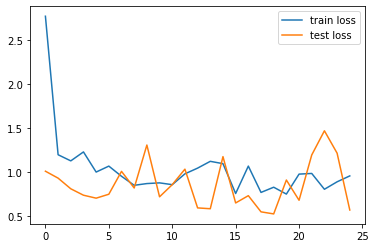

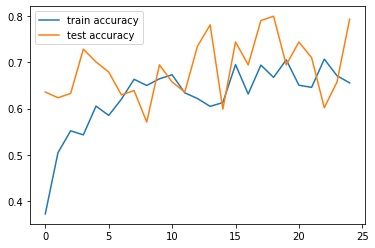

<Figure size 432x288 with 0 Axes>

In [ ]:
## Plot loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('/content/drive/My Drive/google colab/cotton_data/models/resnet50_loss')
plt.clf()

## Plot Accuracy
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()
plt.savefig('/content/drive/My Drive/google colab/cotton_data/models/resnet50_accuracy')
plt.clf()

#### Save Model

In [ ]:
model.save('/content/drive/My Drive/google colab/cotton_data/models/model_resnet50.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = load_model('/content/drive/My Drive/google colab/cotton_data/models/model_resnet50.h5')

In [ ]:
loaded_img = image.load_img('/content/drive/My Drive/google colab/cotton_data/test/diseased cotton leaf/dis_leaf (322).jpg', target_size=(224,224)) # resize to original trained model image size

# image preprocessing
img = image.img_to_array(loaded_img) # convert to array format
print(img.shape)
img = img/255 # rescale
img = np.expand_dims(img, axis=0) # batch of 1 (conv2d require input in [batch, height, width, channels])
print(img.shape)

(224, 224, 3)
(1, 224, 224, 3)


In [ ]:
pred = model.predict(img)
pred = pred.argmax(axis=1)[0]

In [ ]:
pred_classes = {0:'diseased cotton leaf',
                1:'diseased cotton plant',
                2:'fresh cotton leaf',
                3:'fresh cotton plant'}

In [ ]:
print("Prediction - {}".format(pred_classes[pred]))

Prediction - diseased cotton leaf
